In [ ]:
# examine FP rate across different coverage

3585
2430
[1.72046917e-04 2.03386318e-04 1.80361452e-04 1.88036407e-04
 1.50940790e-04 1.05530637e-04 1.20240968e-04 6.07600636e-05
 7.41912356e-05 4.41309936e-05 3.51768789e-05 2.81415032e-05
 4.54101528e-05 1.98269681e-05 3.77351974e-05 3.64560382e-05
 1.66290700e-05 4.47705732e-06 1.02332739e-05 2.55831847e-06
 1.91873885e-06 0.00000000e+00 6.39579617e-07 3.19789809e-06]
319
236
[3.00602420e-05 4.98872101e-05 7.03537579e-06 3.13394012e-05
 1.34311720e-05 7.03537579e-06 7.67495541e-06 1.91873885e-06
 6.39579617e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.27915923e-06 0.00000000e+00 6.39579617e-07 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
60
54
[3.44389025e-05 9.47069818e-06 0.00000000e+00 1.72194512e-06
 0.00000000e+00 0.00000000e+00 8.60972561e-07 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+0

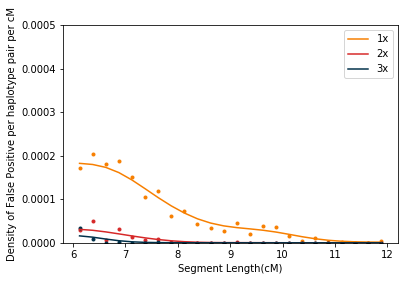

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import pickle

step = 0.25
bins = np.arange(6, 25, step)
binmidpoint = (bins[1:]+bins[:-1])/2

cov2label={'cov1':'1x', 'cov2':'2x', 'cov3':'3x'}
colors = ['#f77f00', '#d62828', '#003049']

pairs2exclude = [('I4893', 'I1507'), ('I4893', 'I5077'), ('I4596', 'I1507'), \
                ('I4596', 'I5233'), ('I1583', 'I3758'), ('I1583', 'I5233'), \
                ('I1507', 'I5233'), ('I3758', 'I5233')]

for cov, color in zip(cov2label.keys(), colors):
    dfs = []
    for b in np.arange(1,101):
        dfs.append(pd.read_csv(f'./{cov}/batch{b}/ch3.tsv', sep='\t'))
    data = pd.concat(dfs)
    for pair in pairs2exclude:
        id1, id2 = pair
        data = data[~((data['iid1'] == id1) & (data['iid2'] == id2))]
        data = data[~((data['iid1'] == id2) & (data['iid2'] == id1))]
    print(len(data))
    data = data[(data['End']-data['Start'])/(100*data['lengthM']) > 220]
    print(len(data))
    fps = np.array(data['lengthM'])
    fps = 100*np.array(fps) # convert to cM 
    y, _ = np.histogram(fps, bins=bins)
    if cov == 'cov3':
        # I5233, I5077 are not included in 3x downsampling,
        # so 5 of the pairs from excluded list do not apply here
        npairs = (11*10/2 - len(pairs2exclude)+5)*100
    else:
        npairs = (13*12/2 - len(pairs2exclude))*100
    y = y/(4*223.361*step*npairs) # convert to rate per haplotype pairs, per centiMorgan
    #plt.plot(binmidpoint, y)
    y_smoothed = gaussian_filter1d(y, 2)
    f = interp1d(binmidpoint, y_smoothed, fill_value='extrapolate')
    pickle.dump(f, open(f'FP.{cov}', 'wb'))
    print(y[:24])
    plt.scatter(binmidpoint[:24], y[:24], marker='.', color=color)
    plt.plot(binmidpoint[:24], f(binmidpoint[:24]), label=f'{cov2label[cov]}', color=color)

plt.legend(loc='upper right')
plt.xlabel('Segment Length(cM)')
plt.ylabel('Density of False Positive per haplotype pair per cM')
plt.ylim([0, 0.0005])
plt.savefig('FP_rate.png', dpi=300, bbox_inches="tight")
plt.savefig('FP_rate.pdf', bbox_inches="tight")